In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

import settings as s
import Hearis as h
from Custom import Mouse

import scipy.io as sio
    
batch = s.Batch()

#water_path = '/home/anverdie/Documents/Code/MFB_Paper/Water'
#mfb_path = '/home/anverdie/Documents/Code/MFB_Paper/MFB'

water_path = '/home/pouple/PhD/Code/MFB_Paper/Water'
mfb_path = '/home/pouple/PhD/Code/MFB_Paper/MFB'

plt.style.use('fivethirtyeight')

In [2]:
class MouseMFB(object):
    def __init__(self, path, verbose=True):
        self.verbose = verbose
        self.path = path
        data = self.__load_data(self.path)
        self.day = data['Day'][0]
        self.corr = data['Correct'][0]
        self.idsound = data['SoundId'][0]
        self.idtrial = data['TrialId'][0]
        self.rule = data['Rule'][0]
        self.WeekDay = data['DayOfWeek'][0]
        
        self.split_in_sessions()
        
        if self.verbose: print('Mouse', os.path.basename(self.path)[1:-4], 'Loaded')
    
    def __load_data(self, path):
        return sio.loadmat(path)
    
    def split_in_sessions(self):
        self.corrs = []
        self.idsounds = []
        self.idtrials = []
        for day in np.unique(self.day):
            indices = np.where(self.day == day)
            self.corrs.append(self.corr[indices])
            self.idsounds.append(self.idsound[indices])
            self.idtrials.append(self.idtrial[indices])
    
    def get_session_score(self):
        scores = [np.sum(corr)*100/len(corr) for corr in self.corrs]
        return scores
    
    def get_best_sessions_scores(self, n_sess):
        best_sess = np.argsort(self.get_session_score())[-n_sess:]
        return best_sess
    def keep_best_sessions(self, n_sess):
        best_sess = self.get_best_sessions_scores(n_sess)
        self.best_corrs = list(np.array(self.corrs, dtype=object)[best_sess])
        self.best_idsounds = list(np.array(self.idsounds, dtype=object)[best_sess])
        self.best_idtrials = list(np.array(self.idtrials, dtype=object)[best_sess])

In [3]:
# Paths for MFB data
# Paths for Water Data
def load_water(batch3=False, tag='PC', rmgaps=False, verbose=True, rmblocks=None):
    mice_id = batch.id_first_batch
    if batch3: mice_id = batch.id_third_batch
    mice_water = [Mouse(path=os.path.join(water_path, f), tag=[tag], collab=False, rmgaps=rmgaps, verbose=verbose, rmblocks=rmblocks) for f in mice_id]
    
    return mice_water 

def load_MFB(tag='PC', verbose=False):
    # Load MFB mice data
    if tag =='PC': path = os.path.join(mfb_path, 'Psychophysics_MFB')
    elif tag =='DIS': path = os.path.join(mfb_path, 'GoVsNoGo_MFB')
    elif tag =='DISC': path = os.path.join(mfb_path, 'GoVsNoGo_ChirpStepLev1_MFB')
    elif tag =='DISC2': path = os.path.join(mfb_path, 'GoVsNoGo_ChirpStepLev2_MFB')

    mice_mfb = os.listdir(path)
    paths = [os.path.join(path, f) for f in os.listdir(path)]
    mice_mfb = [MouseMFB(path, verbose) for path in paths]
    
    return mice_mfb

In [4]:
mice_water_dis = load_water(batch3=True, verbose=False, tag='DIS',rmgaps=True)
mice_mfb_dis = load_MFB(tag='DIS', verbose=False)

In [5]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False)

In [6]:
mice_water_disc = load_water(batch3=True, verbose=False, tag='DISC', rmgaps=True)
mice_mfb_disc = load_MFB(tag='DISC', verbose=False)

# Learning Figure
- Boxplot 1er jour / 1er ensemble de trials supérieur à 80%
    - Ranksum
    - DIS, PC et DISC
    - Display points

0.4178869643175006
0.024027671425442047
0.15637572175964462


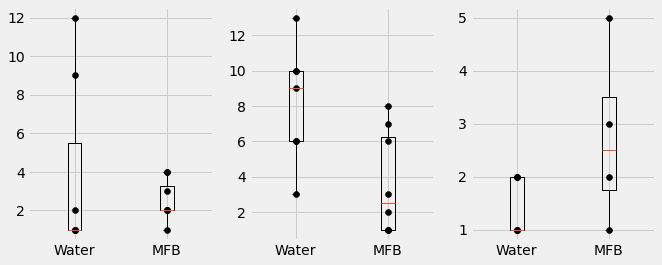

In [7]:
# Need to add ranksum still
# Maybe add jitter on points
from scipy.stats import ranksums

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

####################################### DIS ###########################################
scores_water = [mouse.perf() for mouse in mice_water_dis]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_dis]

# Water
dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]
first_day_over80_water = [np.where(s >= 70)[0][0] + 1 for s in scores_water]

# MFB
first_day_over80_mfb = [np.where(np.array(s) >= 70)[0][0] + 1 for s in scores_mfb]

stdis, pdis = ranksums(first_day_over80_water, first_day_over80_mfb)
print(pdis)
axs[0].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Water', 'MFB'])
axs[0].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[0].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

####################################### PC ###########################################
scores_water = [mouse.perf() for mouse in mice_water_pc]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_pc]

# Water
dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]
first_day_over80_water = [np.where(s >= 80)[0][0] + 1 for s in scores_water]

# MFB
first_day_over80_mfb = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_mfb]

stpc, ppc = ranksums(first_day_over80_water, first_day_over80_mfb)
print(ppc)
axs[1].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Water', 'MFB'])
axs[1].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[1].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

####################################### DISC ###########################################
scores_water = [mouse.perf() for mouse in mice_water_disc]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_disc]

# Water
dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]
first_day_over80_water = [np.where(s >= 60)[0][0] + 1 for s in scores_water]

# MFB####################################### DIS ###########################################

first_day_over80_mfb = [np.where(np.array(s) >= 60)[0][0] + 1 for s in scores_mfb]

stdisc, pdisc = ranksums(first_day_over80_water, first_day_over80_mfb)
print(pdisc)
axs[2].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[2].set_xticks([1, 2])
axs[2].set_xticklabels(['Water', 'MFB'])
axs[2].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[2].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

plt.show()

# Learning curves
Courbe apprentissage pour DIS, PC et DISC. Moyenne avec dernière valeure

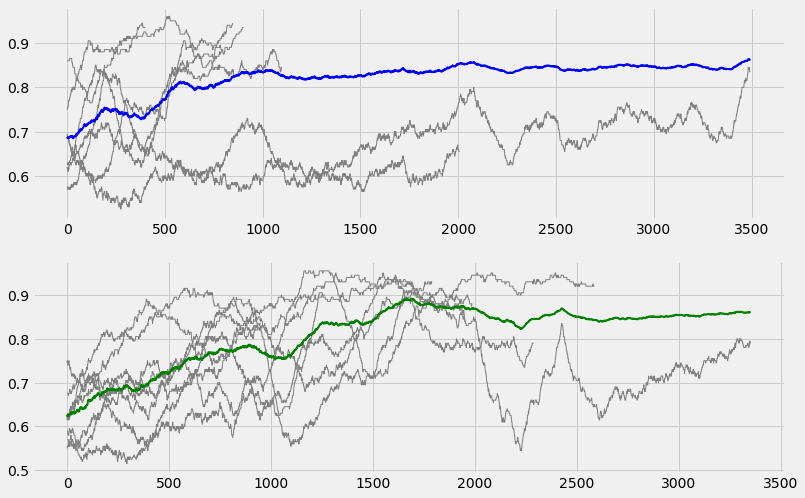

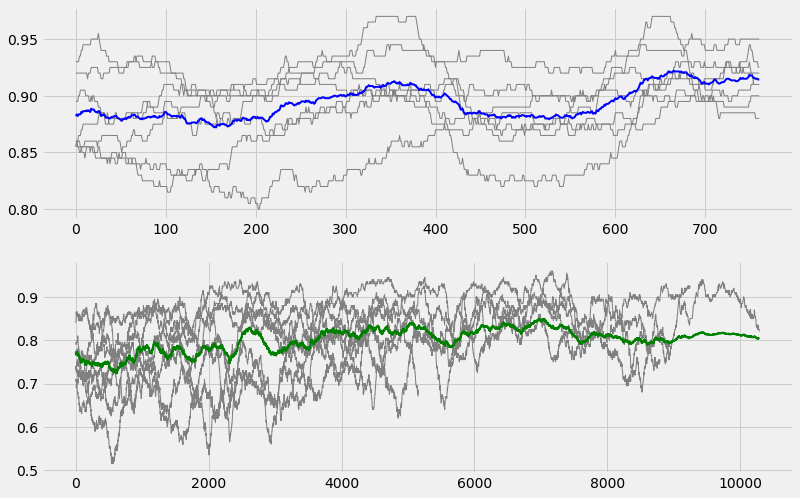

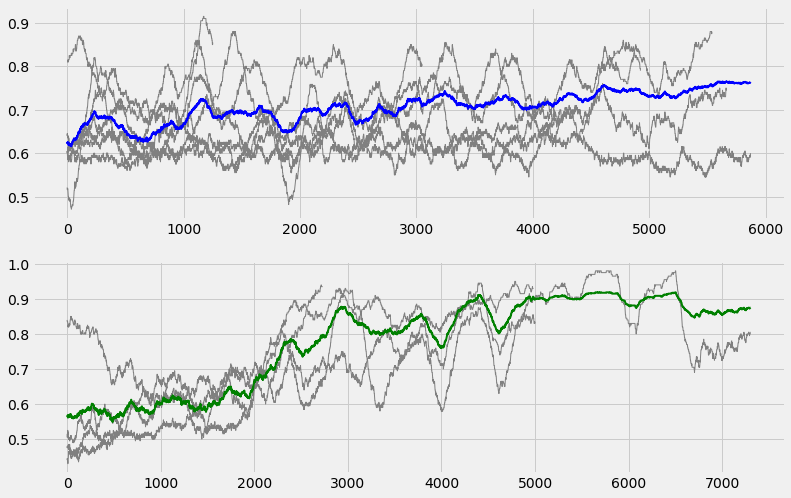

In [12]:
smoothness = 200

####################################### DIS ###########################################
fig, axs = plt.subplots(2, figsize=(12, 8))

all_convo_water = []
for mouse in mice_water_dis:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_water])
axs[0].plot(np.mean(all_convo_water, axis=0), c='blue', linewidth=2)

all_convo_mfb = []
for mouse in mice_mfb_dis:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_mfb])
axs[1].plot(np.mean(all_convo_mfb, axis=0), c='green', linewidth=2)

plt.show()

####################################### PC ###########################################
fig, axs = plt.subplots(2, figsize=(12, 8))

all_convo_water = []
for mouse in mice_water_pc:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_water])
axs[0].plot(np.mean(all_convo_water, axis=0), c='blue', linewidth=2)

all_convo_mfb = []
for mouse in mice_mfb_pc:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_mfb])
axs[1].plot(np.mean(all_convo_mfb, axis=0), c='green', linewidth=2)
plt.show()

####################################### DISC ###########################################
fig, axs = plt.subplots(2, figsize=(12, 8))
all_convo_water = []
for mouse in mice_water_disc:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_water])
axs[0].plot(np.mean(all_convo_water, axis=0), c='blue', linewidth=2)

all_convo_mfb = []
for mouse in mice_mfb_disc:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_mfb])
axs[1].plot(np.mean(all_convo_mfb, axis=0), c='green', linewidth=2)
plt.show()

# Learning
- Psycoacoustic with error bars


In [9]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False)
for mouse in mice_water_pc: mouse.select_best_trials(3)
for mouse in mice_mfb_pc: mouse.keep_best_sessions(3)

Best scores are : [90.     90.3125 90.625 ]
Best scores are : [84.375  85.625  89.0625]
Best scores are : [91.875 92.5   94.375]
Best scores are : [90.3125 91.5625 92.5   ]
Best scores are : [87.1875 89.375  89.375 ]
Best scores are : [86.875 87.5   91.25 ]
Best scores are : [84.6875 85.9375 91.25  ]


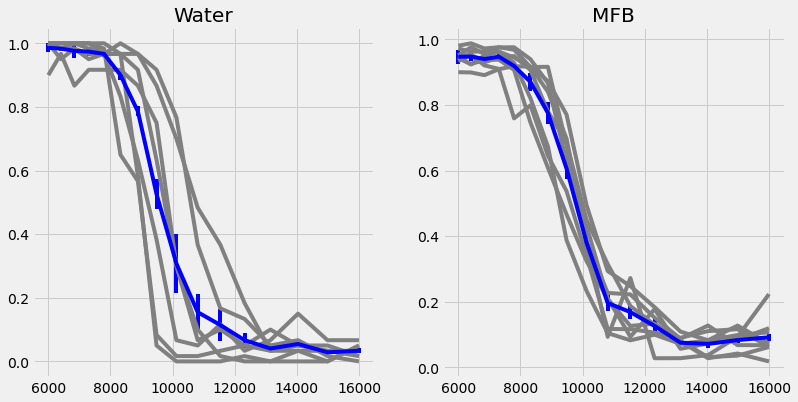

In [10]:
probs = np.array([mouse.psychoacoustic(plot=False)[1] for mouse in mice_water_pc])
probs_reversed = np.array([np.flip(p) if mice_water_pc[i].reversed else p for i, p in enumerate(probs)])
sem_water = np.std(probs_reversed, axis=0) / np.sqrt(probs_reversed.shape[0])
reverse = [mouse.reversed for mouse in mice_water_pc]
probs = [np.abs(1-p) if reverse[i] else p for i, p in enumerate(probs)]

psycos_mfb = np.empty((len(mice_mfb_pc), 16))
for i, mouse in enumerate(mice_mfb_pc):
    all_trailsid = np.concatenate(mouse.best_idtrials)
    all_corr = np.concatenate(mouse.best_corrs)
    all_taskid = np.concatenate(mouse.best_idsounds)
    
    psycho = np.array([c if all_trailsid[i] == 1 else not(c) for i, c in enumerate(all_corr)]) 
    
    scores = np.empty((16,))
    for j, t in enumerate(np.sort(np.unique(all_taskid))):
        idxs = np.where(all_taskid == t)[0]
        curr_corr = psycho[idxs]
        score = np.sum(curr_corr)/len(curr_corr)
        scores[j] = score
    psycos_mfb[i] = scores    

    
probs_mfb_reverse = [np.flip(p) if mice_mfb_pc[i].rule == 'H' else p for i, p in enumerate(psycos_mfb)]
psycos_mfb = [np.abs(1 - s) if mice_mfb_pc[i].rule == 'H' else s for i, s in enumerate(psycos_mfb)]    

probs_mfb_reverse = np.array(probs_mfb_reverse)
sem_mfb = np.std(probs_mfb_reverse, axis=0) / np.sqrt(probs_mfb_reverse.shape[0]) 
psycos_mfb = np.array(psycos_mfb)      
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scale = np.geomspace(6e3, 16e3, 16)
for p in probs:
    axs[0].plot(scale, p, c='gray')
axs[0].errorbar(scale, np.mean(probs, axis=0), yerr=sem_water, c='blue')
axs[0].set_title('Water')


for p in psycos_mfb:
    axs[1].plot(scale, p, c='gray')
axs[1].errorbar(scale, np.mean(psycos_mfb, axis=0), yerr=sem_mfb, c='blue')
axs[1].set_title('MFB')

plt.show()

In [11]:
# Learning curves depending on trials
smoothness = 50
first_day_water = []
for mouse in mice_water:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    axs[0].plot(convo_water, color='grey', linewidth=1)
    first_day_water.append(np.argmax(convo_water > 0.8))

first_day_mfb = []
all_convo_mfb = []
for mouse in mice_mfb:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    first_day_mfb.append(np.argmax(convo_mfb > 0.8))
    all_convo_mfb.append(convo_mfb)
plt.show()
#first_day_water = [f for f in first_day_water if f]
#first_day_mfb = [f for f in first_day_mfb if f]
print(first_day_water, first_day_mfb)
plt.boxplot([first_day_water, first_day_mfb], vert=False)
plt.yticks([1, 2], labels=['Water', 'MFB'])
plt.show() 

NameError: name 'mice_water' is not defined

In [ ]:
# Select only best performing sessions
for mouse in mice_water: mouse.select_best_trials(3)
for mouse in mice_mfb: mouse.keep_best_sessions(3)

### Observation 
There seems to be a log preference shape whern looking at individual mouse in the no go section. Represents the shift around threshold. Maybe good to quantify. PS for MFB seems to have less variance

- peak performance : bar plot go vs nogo sur ⅔ meilleures sessions PS + la courbe PS (en enlevant les essais sans réponse)

In [ ]:
scores_water = np.array([mouse.score_by_task(plot=False) for mouse in mice_water])
mean_scores_water = np.mean(scores_water, axis=0)

scores_mfb = np.empty((len(mice_mfb), 16))
for i, mouse in enumerate(mice_mfb):
    all_taskid = np.concatenate(mouse.best_idsounds)
    all_corr = np.concatenate(mouse.best_corrs)
    
    for t in np.sort(np.unique(all_taskid)):
        idxs = np.where(all_taskid == t)[0]
        curr_corr = all_corr[idxs]
        scores_mfb[i] = (np.sum(curr_corr)*100/len(curr_corr))
mean_scores_mfb = np.mean(scores_mfb, axis=0)

# Psycoacoustics 
probs = np.array([mouse.psychoacoustic(plot=False)[1] for mouse in mice_water])
reverse = [mouse.reversed for mouse in mice_water]
probs = [np.abs(1-p) if reverse[i] else p for i, p in enumerate(probs)]

psycos_mfb = np.empty((len(mice_mfb), 16))
for i, mouse in enumerate(mice_mfb):
    all_trailsid = np.concatenate(mouse.best_idtrials)
    all_corr = np.concatenate(mouse.best_corrs)
    all_taskid = np.concatenate(mouse.best_idsounds)
    
    psycho = np.array([c if all_trailsid[i] == 1 else not(c) for i, c in enumerate(all_corr)]) 
    
    scores = np.empty((16,))
    for j, t in enumerate(np.sort(np.unique(all_taskid))):
        idxs = np.where(all_taskid == t)[0]
        curr_corr = psycho[idxs]
        score = np.sum(curr_corr)*100/len(curr_corr)
        scores[j] = score

    psycos_mfb[i] = scores
psycos_mfb = [np.abs(100 - s) if mice_mfb[i].rule == 'H' else s for i, s in enumerate(psycos_mfb)]    
psycos_mfb = np.array(psycos_mfb)      
        
fig, axs = plt.subplots(1, 2, figsize=(4, 6))

axs[0].bar([1, 2], [np.mean(mean_scores_water[:8]), np.mean(mean_scores_water[8:])])
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Go', 'NoGo'])
axs[0].set_yticks(np.linspace(0, 90, 10))
axs[0].set_title('Water')

axs[1].bar([1, 2], [np.mean(mean_scores_mfb[:8]), np.mean(mean_scores_mfb[8:])])
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Go', 'NoGo'])
axs[1].set_yticks(np.linspace(0, 90, 10))
axs[1].set_title('MFB')

plt.show()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scale = np.geomspace(6e3, 16e3, 16)
for p in probs:
    axs[0].plot(scale, p, c='gray')
axs[0].plot(scale, np.mean(probs, axis=0), c='blue')
axs[0].set_title('Water')


for p in psycos_mfb:
    axs[1].plot(scale, p/100, c='gray')
axs[1].plot(scale, np.mean(psycos_mfb/100, axis=0), c='blue')
axs[1].set_title('MFB')

plt.show()## MISSING REMOVE BLOCKS WITH NO RESPONSES## MISSING REMOVE BLOCKS WITH NO RESPONSES

# learning rates 
- on discrimination frequency and psychophysics frequency : courbe accuracy en fct du nombre d’essais (avec et sans tri essais sans réponse) + en fct du nombre de jours (avec et sans tri essais sans réponse)
- learning rate (temps pour arriver à 80%)
- learning rate on to chirp vs 2 step discrimination (à voir où on place)


In [ ]:
mice_water = load_water(batch3=False, rmgaps=True)
mice_mfb = load_MFB()

In [ ]:
from datetime import date

scores_water = [mouse.perf() for mouse in mice_water]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb]
first_day_over80_mfb = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_mfb]

dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]

# First days at 80
first_day_over80_water = [np.where(s >= 80)[0][0] + 1 for s in scores_water]

plt.boxplot([first_day_over80_water, first_day_over80_mfb], vert=False)
plt.yticks([1, 2], labels=['Water', 'MFB'])
plt.show()

# Learning curves depending on days
fig, axs = plt.subplots(2, figsize=(15, 10))
for i, s in enumerate(scores_water):
    #axs[0].plot(dates[i][0], s, color='grey', marker='o', markersize=8)
    axs[0].plot(s, color='grey', marker='o', markersize=8)
axs[0].set_title('Water')
axs[0].set_ylim((40, 100))
axs[0].set_xlim((0, 30))

for i, s in enumerate(scores_mfb):
    axs[1].plot(s, color='grey', marker='o', markersize=8)
axs[1].set_title('MFB')
axs[1].set_ylim((40, 100))
axs[1].set_xlim((0, 30))
plt.show()

# Learning curves depending on trials
fig, axs = plt.subplots(2, figsize=(12, 8))
smoothness = 50
first_day_water = []
for mouse in mice_water:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    axs[0].plot(convo_water, color='grey', linewidth=1)
    first_day_water.append(np.argmax(convo_water > 0.8))

first_day_mfb = []
all_convo_mfb = []
for mouse in mice_mfb:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    first_day_mfb.append(np.argmax(convo_mfb > 0.8))
    all_convo_mfb.append(convo_mfb)
plt.show()
#first_day_water = [f for f in first_day_water if f]
#first_day_mfb = [f for f in first_day_mfb if f]
print(first_day_water, first_day_mfb)
plt.boxplot([first_day_water, first_day_mfb], vert=False)
plt.yticks([1, 2], labels=['Water', 'MFB'])
plt.show() 

In [ ]:
mice_water = load_water(batch3=False, tag='DIS', verbose=False)
mice_mfb = load_MFB(tag='DIS')

In [ ]:
from datetime import date

scores_water = [mouse.perf() for mouse in mice_water]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb]
first_day_over80_mfb = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_mfb]

dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]

# First days at 80
first_day_over80_water = [np.where(s >= 80)[0][0] + 1 for s in scores_water]

plt.boxplot([first_day_over80_water, first_day_over80_mfb], vert=False)
plt.yticks([1, 2], labels=['Water', 'MFB'])
plt.show()

# Learning curves depending on days
fig, axs = plt.subplots(2, figsize=(15, 10))
for i, s in enumerate(scores_water):
    #axs[0].plot(dates[i][0], s, color='grey', marker='o', markersize=8)
    axs[0].plot(s, color='grey', marker='o', markersize=8)
axs[0].set_title('Water')
axs[0].set_ylim((40, 100))
axs[0].set_xlim((0, 30))

for i, s in enumerate(scores_mfb):
    axs[1].plot(s, color='grey', marker='o', markersize=8)
axs[1].set_title('MFB')
axs[1].set_ylim((40, 100))
axs[1].set_xlim((0, 30))

plt.show()
# Learning curves depending on trials
fig, axs = plt.subplots(2, figsize=(12, 8))
smoothness = 200

first_day_water = []
for mouse in mice_water:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    axs[0].plot(convo_water, color='grey', linewidth=1)
    first_day_water.append(np.argmax(convo_water > 0.8))
    

first_day_mfb = []
for mouse in mice_mfb:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    first_day_mfb.append(np.argmax(convo_mfb > 0.8))

   

plt.show() 
print(first_day_water, first_day_mfb)
plt.boxplot([first_day_water, first_day_mfb], vert=False)
plt.yticks([1, 2], labels=['Water', 'MFB'])
plt.show()

In [ ]:
# Learning rate on to chirp vs 2 step discrimination (à voir où on place)
mice_water = load_water(batch3=True, tag='DISC2', rmgaps=True)
mice_mfb = load_MFB(tag='DISC2')

In [ ]:
from datetime import date

scores_water = [mouse.perf() for mouse in mice_water]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb]
first_day_over80_mfb = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_mfb]

dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]

# First days at 80
#first_day_over80_water = [np.where(s >= 80)[0][0] + 1 for s in scores_water]

#plt.boxplot([first_day_over80_water, first_day_over80_mfb], vert=False)
#plt.yticks([1, 2], labels=['Water', 'MFB'])
#plt.show()

# Learning curves depending on days
fig, axs = plt.subplots(2, figsize=(15, 10))
for i, s in enumerate(scores_water):
    #axs[0].plot(dates[i][0], s, color='grey', marker='o', markersize=8)
    axs[0].plot(s, color='grey', marker='o', markersize=8)
axs[0].set_title('Water')
axs[0].set_ylim((40, 100))
axs[0].set_xlim((0, 30))

for i, s in enumerate(scores_mfb):
    axs[1].plot(s, color='grey', marker='o', markersize=8)
axs[1].set_title('MFB')
axs[1].set_ylim((40, 100))
axs[1].set_xlim((0, 30))
plt.show()

# Learning curves depending on trials
fig, axs = plt.subplots(2, figsize=(12, 8))
smoothness = 200
for mouse in mice_water:
    files = mouse.elphy
    if files:
        tasks = np.concatenate([f.tr_corr for f in files])
        convo = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
        axs[0].plot(convo, color='grey', linewidth=1)

for mouse in mice_mfb:p x > k
    all_corrs = np.concatenate(mouse.corrs)
    convo = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo, color='grey', linewidth=1)
plt.show() 

# Stability in time
- Stability in time (week)
- go probability on 300 first trials during week - DONE
- performance on 300 first trials Friday vs Monday
- number of max trials per session (PS) - DONE
- 3 meilleures sessions PS : proba qu’un essai soit dans un bloc réussi (go vs no go) / motivé (go) de longeur > n, n croissant
	- possibility of speeding up trials withou loss of accuracy
    

In [ ]:
mice_water = load_water(batch3=False, tag='PC')
mice_mfb = load_MFB(tag='PC')

In [ ]:
# Go prob during the first 300 trials of the week
import datetime
mfb_monday_scores = []
for mouse in mice_mfb:
    mondays = np.where(np.array(mouse.WeekDay) == 2)[0]
    mfb_monday_score = []
    print(np.unique(mouse.day[mondays]))
    for m in np.unique(mouse.day[mondays]):
        # Weird comparison
        curr_monday = np.where(mouse.day[mondays] == m)
        first_300_mondays = curr_monday[:300]
        first_corr = np.array(mouse.corr)[first_300_mondays]
        first_trialid = np.array(mouse.idtrial)[first_300_mondays]
        first_gos = np.where(first_trialid == 1)[0]
        mfb_monday_score.append(np.sum(first_corr[first_gos])/len(first_gos))
    mfb_monday_scores.append(mfb_monday_score)
print(mfb_monday_scores) # How to plot this thing ? 

for mouse in mice_water:
    perf, dates = mouse.perf()
    dates = [d.astype('datetime64[D]') for d in dates]
    mondays = np.is_busday(dates, weekmask='Mon')
    files = [f for i, f in enumerate(mouse.elphy) if mondays[i]]
    # Just get the goes ? 

In [ ]:
mice_water = load_water(batch3=False)
mice_mfb = load_MFB()

In [ ]:
# One could argue that we cap this value on purpose, so how to measure motivation ? 
max_ntrials_mfb = np.array([np.max([len(c) for c in mouse.corrs]) for mouse in mice_mfb])
max_ntrials_water = []
for mouse in mice_water:
    files = mouse.elphy
    dates = [f.date for f in files]
    ntrials_water = [len(f.tr_corr) for f in files]
    if not len(dates) == len(np.unique(dates)):
        for i, d in enumerate(dates):
            if dates.count(d) > 1:
                idxs = np.where(np.array(dates) == d)[0]
                ntrials_water.append(np.sum([len(files[i].tr_corr) for i in idxs]))
    max_ntrials_water.append(np.max(ntrials_water))
    
plt.bar([1, 2], [np.max(max_ntrials_water), np.max(max_ntrials_mfb)])
plt.xticks(ticks=[1, 2], labels=['Water', 'MFB'])

    
#sns.barplot(y=max_ntrials_mfb, capsize=.1, ci="sd")
#sns.swarmplot(y=max_ntrials_mfb, color="0", alpha=.35)

#sns.barplot(y=max_ntrials_water, capsize=.1, ci="sd")
#sns.swarmplot(y=max_ntrials_water, color="0", alpha=.35)

plt.show()
    

# flexibility (one could worry mfb becomes very fixed behaviour)
- refer to no go performance
- licking vs fork on go nogo show that no pressing at all
- we show animals can switch task : speed of change from go / compare first and second learning phase
	- look at perseverance (probability to go for nogo after many rewards for ex)
Wait time between trials


In [ ]:
# Figure with four panel about compacticity
# Evolution de la proba do go/nogo au cours d'un trial particulier

In [ ]:
mice_water = load_water(batch3=True)
mice_mfb = load_MFB()

In [ ]:
smoothness = 10

unique_mouse = mice_water[0]
perfs_unique, dates = unique_mouse.perf()
last_session = unique_mouse.elphy[4]

trtype = last_session.tr_type
trcorr = last_session.tr_corr

if unique_mouse.reversed:
    trtype = [1 if t < 9 else 0 for t in trtype]
else:
    trtype = [0 if t < 9 else 1 for t in trtype]

gos = [c for c, t in zip(trcorr, trtype) if t]
nogos = [c for c, t in zip(trcorr, trtype) if not t]

conv_gos = np.convolve(gos, np.ones(smoothness)/smoothness, mode='valid')
conv_nogos = np.convolve(nogos, np.ones(smoothness)/smoothness, mode='valid')

plt.plot(conv_gos, c='green')
plt.plot(conv_nogos, c='red')
plt.show()

In [ ]:
smoothness = 10
print(len(mice_mfb))
mouse = mice_mfb[2]
corrs = np.array(mouse.corrs[0])
idtrials = np.array(mouse.idtrials[0])



gos = [c for c, t in zip(corrs, idtrials) if t == 1]
nogos = [c for c, t in zip(corrs, idtrials) if t == 2]

conv_gos = np.convolve(gos, np.ones(smoothness)/smoothness, mode='valid')
conv_nogos = np.convolve(nogos, np.ones(smoothness)/smoothness, mode='valid')

plt.plot(conv_gos, c='green', label='go')
plt.plot(conv_nogos, c='red', label='nogo')
plt.legend()

plt.show() 